In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import linkage, dendrogram

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.utils import load_config, seed_everything, calculate_cv_per_class, calculate_d_ratio, calculate_detection_rate

In [2]:
# for reproducibility
seed_everything(42)

# config file
config = load_config("../configs/config.yaml")

# Set Seaborn style
sns.set(style=config['sns_params']['style'],
        palette=config['sns_params']['palette'],
        font_scale=config['sns_params']['font_scale'])

# Set Matplotlib parameters
plt.rcParams.update(config['plt_params'])

### Read files and take a first look

In [3]:
data_mat = pd.read_csv(config['paths']['data_mat_path'])
data_mat.head(5)

,sample,FT-000,FT-001,FT-002,FT-003,FT-004,FT-005,FT-006,FT-007,FT-008,...,FT-242,FT-243,FT-244,FT-245,FT-246,FT-247,FT-248,FT-249,FT-250,FT-251
0,20241106-297-Blank1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,20241106-297-Blank2,0.0,0.000000,0.0,5.770641,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.534493,0.0,0.0,0.0
2,20241106-297-Blank3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.469501,0.0,0.0,0.0
3,20241106-297-Blank4,0.0,5.497865,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,20241106-297-Blank5,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [4]:
feat_meta = pd.read_csv(config['paths']['feat_meta_path'])
feat_meta.head(5)

,feature,mz,mz max,mz min,mz std,rt,rt end,rt max,rt min,rt start,rt std
0,FT-000,359.108768,359.130591,359.090122,0.010955,543.846374,561.270879,546.697803,539.941156,528.714227,1.683901
1,FT-001,357.109546,357.130018,357.091871,0.010668,543.839157,563.021530,546.948017,540.038924,528.530311,1.662290
2,FT-002,889.649931,889.702216,889.601547,0.025552,609.099742,627.717251,611.746501,606.426553,596.789046,1.324647
3,FT-003,355.111928,355.132772,355.093653,0.010508,543.995269,566.951285,547.164503,540.681882,526.943213,1.609071
4,FT-004,888.645365,888.696941,888.600202,0.026161,609.255652,632.996442,612.008732,606.778809,595.461688,1.254684


In [5]:
sample_meta = pd.read_csv(config['paths']['sample_meta_path'])
sample_meta.head(5)

,sample,class,id,order,batch
0,20241106-297-Blank1,B,20241106-297-Blank1,1,1
1,20241106-297-Blank2,B,20241106-297-Blank2,2,1
2,20241106-297-Blank3,B,20241106-297-Blank3,3,1
3,20241106-297-Blank4,B,20241106-297-Blank4,102,1
4,20241106-297-Blank5,B,20241106-297-Blank5,103,1


In [6]:
exog_stand = pd.read_csv(config['paths']['exog_stan_path'])
exog_stand

,compound_id,mz,Retention_time
0,GU4,886.40,610
1,GU5,1048.45,753
2,GU14,1253.96,1500
3,GU15,1334.99,1551


### Some basic stats and plots

In [7]:
print(f'Number of missing values in data matrix: {data_mat.isna().sum().sum()}')

Number of missing values in data matrix: 0


<Figure size 800x600 with 0 Axes>

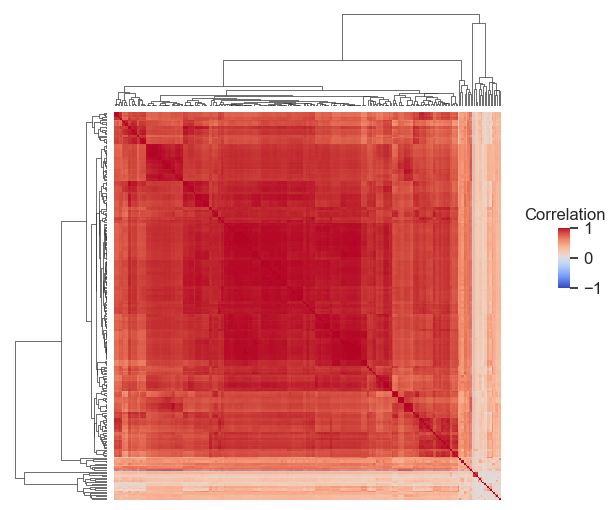

In [8]:
ft_columns = [col for col in data_mat.columns if col.startswith('FT')]

# Features pairwise correlations
corr_matrix = data_mat[ft_columns].corr()

# Compute linkage for clustering
linkage_matrix = linkage(corr_matrix, method='average')

plt.figure()
g = sns.clustermap(
    corr_matrix, 
    row_linkage=linkage_matrix, 
    col_linkage=linkage_matrix, 
    cmap="coolwarm", 
    annot=False,
    vmin=-1,
    vmax=1,
    figsize=(6,6))

# Further customize tick label sizes
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.cax.set_position([0.95, 0.5, 0.02, 0.1]) 
g.cax.set_title("Correlation") 
plt.savefig(f"{config['paths']['figures_dir']}/features_corr.png")
plt.show()

<Figure size 800x600 with 0 Axes>

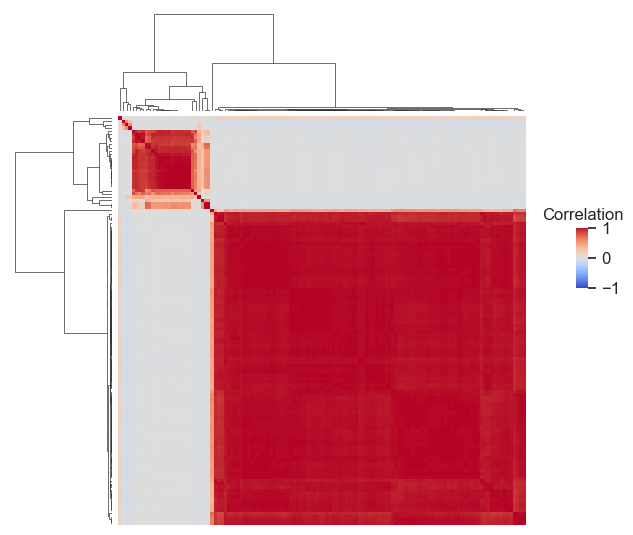

In [9]:
ft_columns = [col for col in data_mat.columns if col.startswith('FT')]

# Features pairwise correlations
corr_matrix = data_mat[ft_columns].T.corr()

# Compute linkage for clustering
linkage_matrix = linkage(corr_matrix, method='average')

plt.figure()
g = sns.clustermap(
    corr_matrix, 
    row_linkage=linkage_matrix, 
    col_linkage=linkage_matrix, 
    cmap="coolwarm", 
    annot=False,
    vmin=-1,
    vmax=1,
    figsize=(6,6))

# Further customize tick label sizes
g.cax.set_position([0.98, 0.5, 0.02, 0.1]) 
g.ax_heatmap.set_xticks([])
g.ax_heatmap.set_yticks([])
g.cax.set_title("Correlation") 
plt.savefig(f"{config['paths']['figures_dir']}/samples_corr.png")
plt.show()

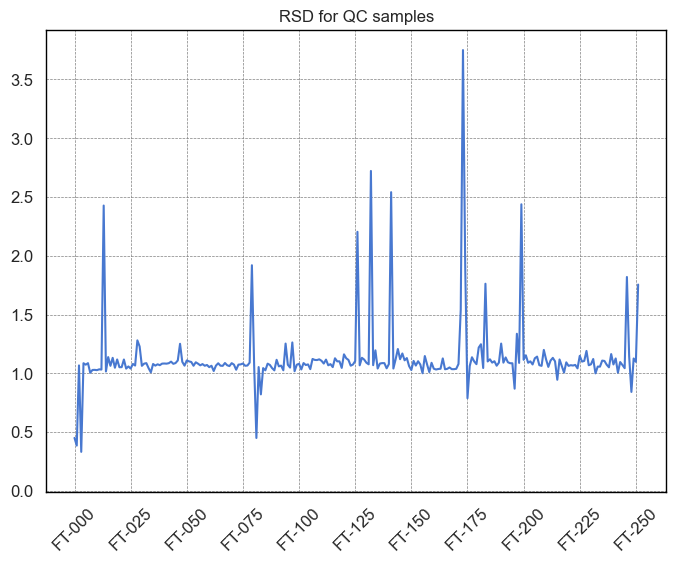

In [10]:
# Calculate RSD for QC samples
qc_samples = sample_meta[sample_meta['class'].str.contains('QC')]
qc_data = data_mat.loc[data_mat['sample'].isin(qc_samples['sample']), ft_columns]
rsd = qc_data.std(axis=0) / qc_data.mean(axis=0)

plt.figure()
rsd.plot(kind='line')
plt.xticks(ticks=range(0, len(rsd), 25), labels=[f'FT-{i:03}' for i in range(0, len(rsd), 25)], rotation=45)
plt.ylim(-.01, )
plt.title('RSD for QC samples')
plt.savefig(f"{config['paths']['figures_dir']}/rsd_for_qc_samples.png")
plt.show()

In [11]:
cv_df = calculate_cv_per_class(data_mat, sample_meta)
cv_df

,class,FT-000,FT-001,FT-002,FT-003,FT-004,FT-005,FT-006,FT-007,FT-008,...,FT-242,FT-243,FT-244,FT-245,FT-246,FT-247,FT-248,FT-249,FT-250,FT-251
0,B,1.643249,1.529699,NaN,2.043100,NaN,NaN,NaN,NaN,NaN,...,NaN,3.316625,2.253248,3.316625,NaN,NaN,2.338963,NaN,NaN,NaN
1,dQC,0.316362,0.310090,1.149730,0.304755,1.168879,1.152869,1.167743,1.019173,1.052552,...,1.077021,1.180627,1.095578,1.118832,3.022084,1.064716,0.827060,1.111774,1.104260,2.782772
2,Dunn,0.083354,0.090343,0.312634,0.091189,0.310834,0.291509,0.312270,0.150186,0.141874,...,0.347098,0.202888,0.201829,0.285717,0.383964,0.249434,0.143965,0.242138,0.161023,1.558218
3,SS,0.320862,0.348790,1.414214,0.263458,1.414214,1.414214,1.414214,1.414214,1.414214,...,NaN,NaN,NaN,NaN,1.414214,1.414214,NaN,NaN,NaN,1.414214
4,French,0.113385,0.094959,0.214364,0.092923,0.216498,0.172595,0.200124,0.092619,0.091243,...,0.279395,0.243327,0.241317,0.352181,0.208867,0.459429,0.130532,0.211294,0.136625,0.269884
5,LMU,0.119320,0.115566,0.309540,0.110299,0.307217,0.264032,0.293647,0.144113,0.142729,...,0.232675,0.262654,0.198125,0.308745,2.713183,0.430967,0.175193,0.259900,0.176652,1.542990
6,QC,0.475538,0.407507,1.032250,0.335532,1.056872,1.052403,1.058605,1.019034,1.039791,...,0.992230,1.009704,1.066782,0.985666,1.531976,1.207309,0.803797,1.085948,1.052998,1.432441


In [12]:
### Dratio

# Identify QC and biological samples from acquisition_list
qc_samples = sample_meta[sample_meta['class'].str.contains('QC')]['sample']
bio_samples = sample_meta[sample_meta['class'].isin(['Dunn', 'French', 'LMU'])]['sample']

# Combine results into a summary DataFrame
d_ratio = calculate_d_ratio(data_mat, qc_samples, bio_samples)

d_ratio

,Feature,QC_CV,Bio_CV,D_Ratio
0,FT-000,0.450246,0.107050,4.393979
1,FT-001,0.384868,0.101771,4.303110
2,FT-002,1.066857,0.281652,1.822812
3,FT-003,0.331517,0.099530,3.914927
4,FT-004,1.085526,0.282348,1.849177
...,...,...,...,...
246,FT-246,1.819215,0.775156,0.600648
247,FT-247,1.143901,0.460630,1.445438
248,FT-248,0.841326,0.199504,2.192581
249,FT-249,1.125936,0.296631,1.568576


In [13]:
detection_rate = calculate_detection_rate(data_mat, sample_meta)
detection_rate

,class,FT-000,FT-001,FT-002,FT-003,FT-004,FT-005,FT-006,FT-007,FT-008,...,FT-242,FT-243,FT-244,FT-245,FT-246,FT-247,FT-248,FT-249,FT-250,FT-251
0,B,0.363636,0.454545,0.000000,0.363636,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.090909,0.181818,0.090909,0.000000,0.000000,0.181818,0.0,0.000000,0.000000
1,Dunn,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.370370
2,French,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000
3,LMU,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.423077,1.000000,1.000000,1.0,1.000000,0.461538
4,QC,1.000000,1.000000,0.681818,1.000000,0.590909,0.5,0.545455,0.818182,0.590909,...,0.818182,0.818182,0.545455,0.863636,0.409091,0.545455,1.000000,0.5,0.636364,0.409091
5,SS,1.000000,1.000000,0.500000,1.000000,0.500000,0.5,0.500000,0.500000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0.0,0.000000,0.500000
6,dQC,1.000000,1.000000,0.700000,1.000000,0.700000,0.5,0.700000,0.800000,0.600000,...,0.600000,0.600000,0.600000,0.700000,0.300000,0.600000,1.000000,0.5,0.600000,0.200000


### Q1. How many features have been detected, how is the distribution across mz and retention time, and across classes?

In [7]:
print(f'Number of features: {data_mat.shape[1]-1}')
print(f'Number of samples: {data_mat.shape[0]}')

Number of features: 252
Number of samples: 124


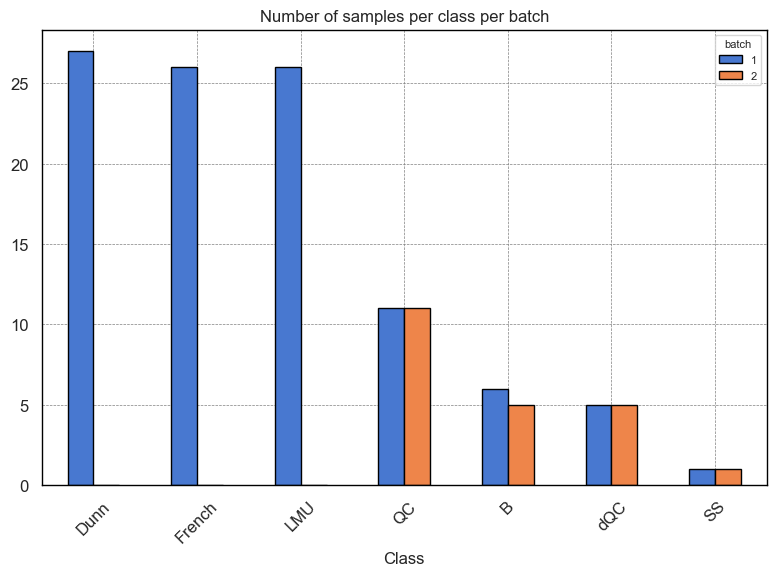

In [10]:
# Group and pivot the data
class_batch_counts = sample_meta.groupby(['class', 'batch']).size().unstack(fill_value=0)

# Sort by total count across batches
class_batch_counts['Total'] = class_batch_counts.sum(axis=1)
class_batch_counts = class_batch_counts.sort_values(by='Total', ascending=False).drop(columns='Total')

# Plot grouped bar plot
class_batch_counts.plot(kind='bar', edgecolor='black')
plt.title('Number of samples per class per batch')
plt.xlabel('Class')
plt.legend(title='batch')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{config['paths']['figures_dir']}/nsamples_perclass_perbatch.png")
plt.show()

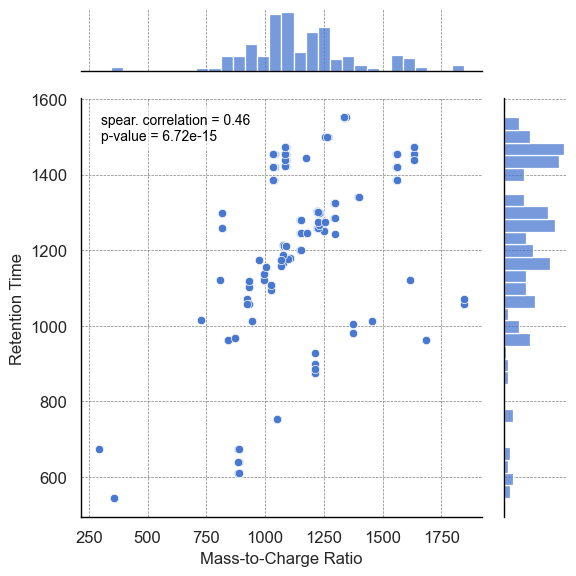

In [29]:
# Calculate correlation
spearman_corr, pval = spearmanr(feat_meta['mz'], feat_meta['rt'])

# Jointplot with marginal distributions
joint_plot = sns.jointplot(
    data=feat_meta,
    x='mz',
    y='rt',
    kind='scatter',
    marginal_kws=dict(bins=30, fill=True),
    space=0.2,
)

# Add correlation to plot
joint_plot.ax_joint.text(
    0.05, 0.9, f"spear. correlation = {spearman_corr:.2f}\np-value = {pval:.2e}", 
    transform=joint_plot.ax_joint.transAxes,
    fontsize=10, color="black", bbox=dict(facecolor='white', alpha=0.5)
)

joint_plot.set_axis_labels('Mass-to-Charge Ratio', 'Retention Time')
plt.tight_layout()
plt.savefig(f"{config['paths']['figures_dir']}/rt_vs_mz.png")
plt.show()


<Figure size 2000x1000 with 0 Axes>

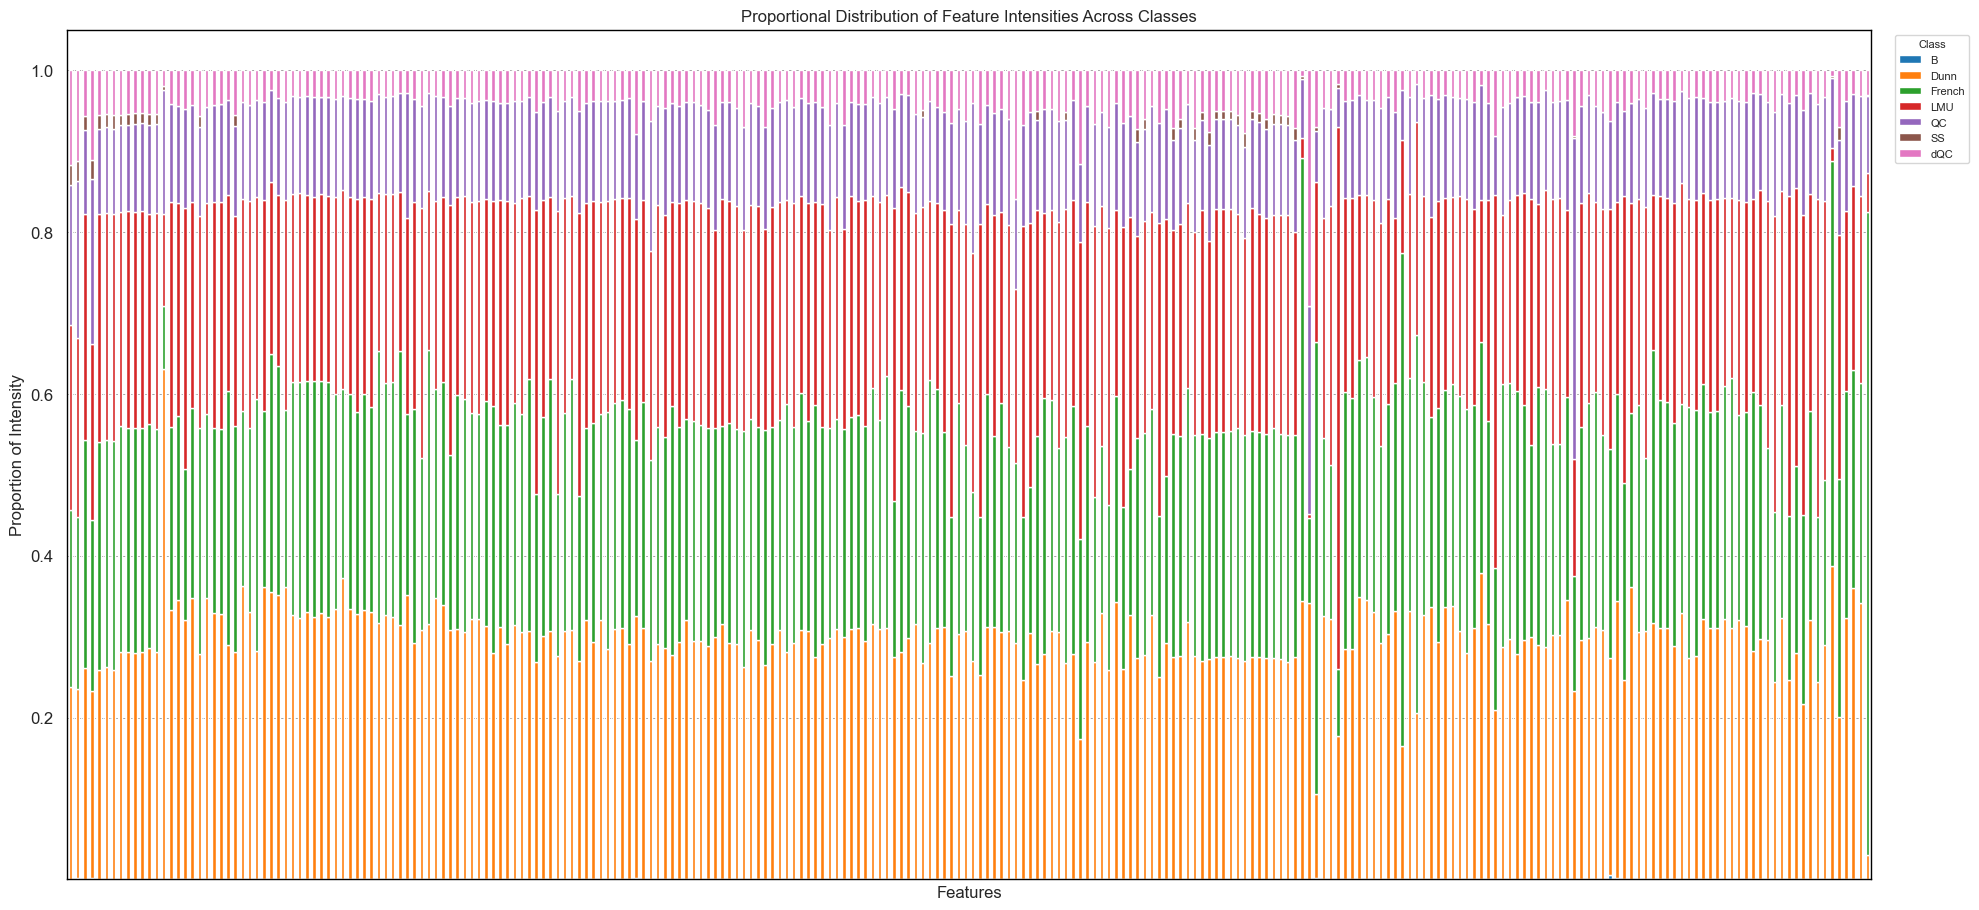

In [30]:
# Melt data_matrix for class-level analysis
intensity_long = data_mat.melt(id_vars='sample', var_name='feature', value_name='intensity')

# Merge with acquisition_list to add class labels
intensity_long = intensity_long.merge(sample_meta[['sample', 'class']], on='sample')

# Replace zero intensities with NaN for presence/absence analysis
intensity_long['intensity'] = intensity_long['intensity'].replace(0, pd.NA)

# Calculate the total intensity for each feature by class
feature_class_intensity = intensity_long.groupby(['feature', 'class'])['intensity'].sum().unstack(fill_value=0)

# Calculate the proportion of intensity per class for each feature
feature_class_proportions = feature_class_intensity.div(feature_class_intensity.sum(axis=1), axis=0)

# Plot the proportional stacked bar plot
plt.figure(figsize=(20, 10))
feature_class_proportions.plot(kind='bar', stacked=True, figsize=(20, 10), color=sns.color_palette("tab10"))

plt.title('Proportional Distribution of Feature Intensities Across Classes')
plt.xlabel('Features')
plt.ylabel('Proportion of Intensity')
plt.legend(title='Class', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.xticks([]) 
plt.savefig(f"{config['paths']['figures_dir']}/prop_intensities_in_classes.png")
plt.show()

### 2. How is the contamination in the experiment?

In [31]:
# extract Blank samples
data_mat_blank = data_mat.merge(sample_meta[['sample', 'class', 'batch']], how='left')
data_mat_blank = data_mat_blank[data_mat_blank['class'] == 'B']
ft_columns = [col for col in data_mat.columns if col.startswith('FT')]
data_mat_blank_melt = data_mat_blank[ft_columns + ['sample', 'batch']].melt(id_vars=['sample', 'batch'], var_name='feature', value_name='intensity')

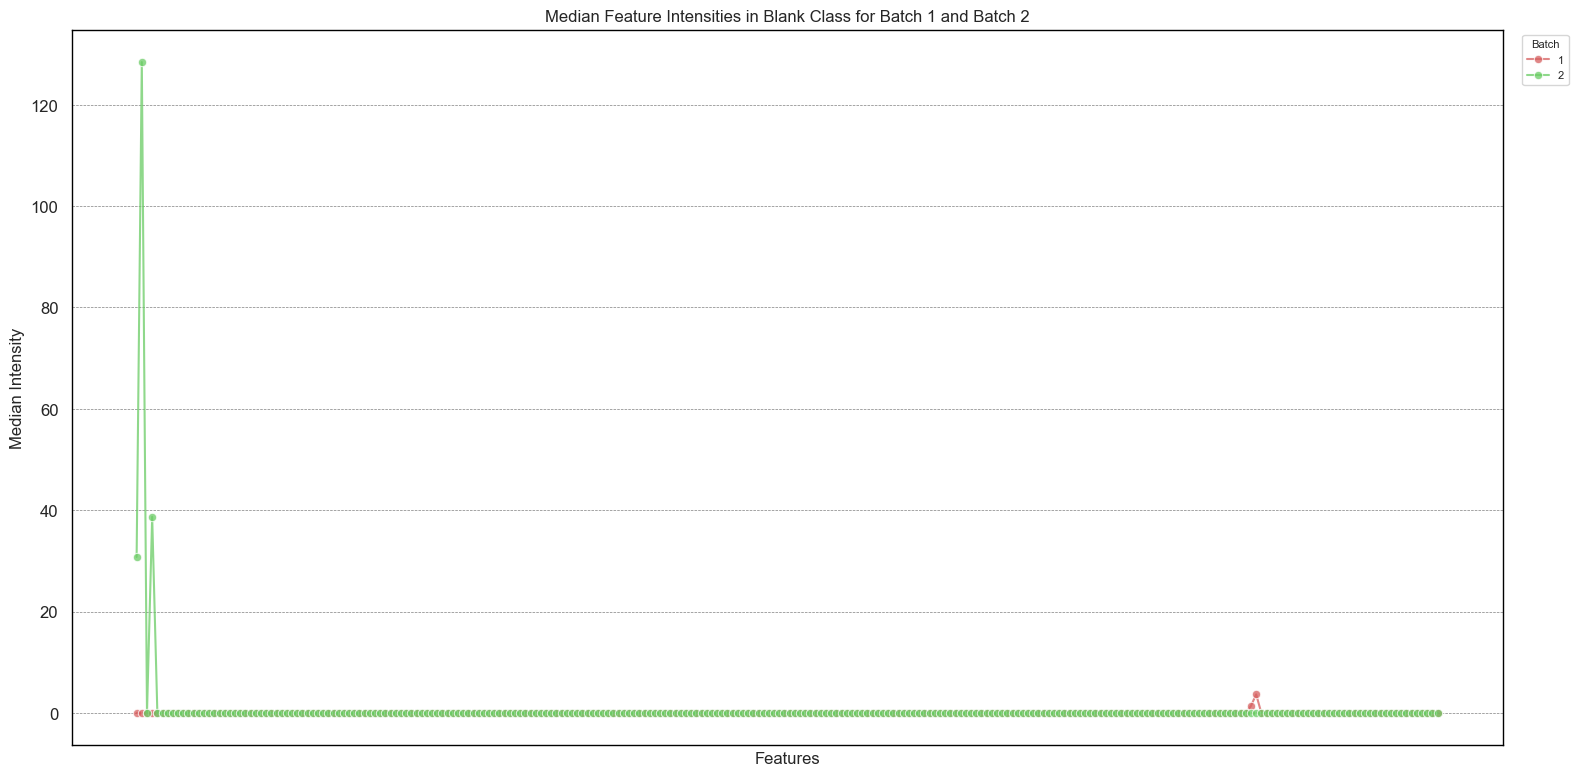

In [41]:
mean_intensities = data_mat_blank_melt.groupby(['feature', 'batch'])['intensity'].median().reset_index()

plt.figure(figsize=(16, 8))
sns.lineplot(data=mean_intensities, x='feature', y='intensity', hue='batch', marker='o', alpha=0.75, palette=['r', 'g'])
plt.title('Median Feature Intensities in Blank Class for Batch 1 and Batch 2')
plt.xlabel('Features')
plt.ylabel('Median Intensity')
plt.xticks([])  
plt.legend(title='Batch', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{config['paths']['figures_dir']}/median_blank_intensity_features.png")
plt.show()

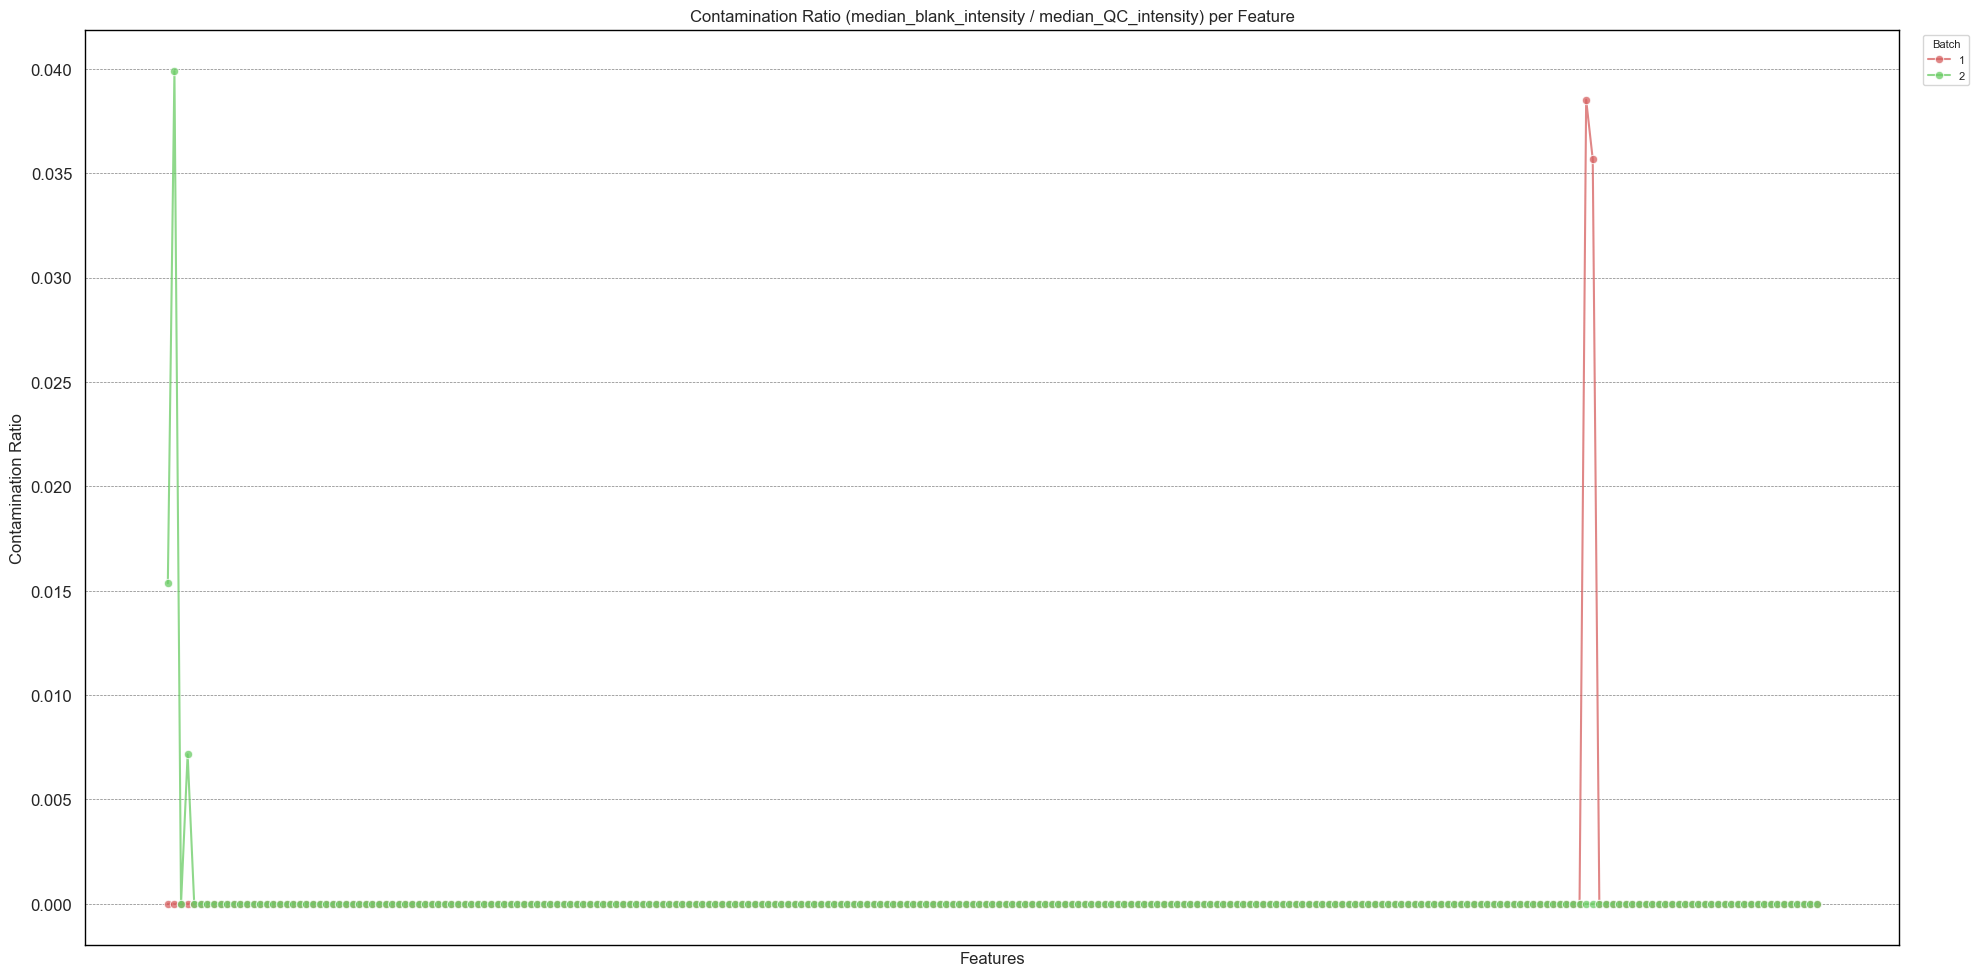

In [42]:
# Merge sample metadata with data_matrix
data_mat2 = data_mat.merge(sample_meta[['sample', 'class', 'batch']], on='sample', how='left')

# Create an empty DataFrame to store batch-level contamination ratios
batch_contamination_df = pd.DataFrame()

# Loop through each batch
for batch in data_mat2['batch'].unique():
    if pd.isna(batch):
        continue
    
    # Subset Blank and Non-Blank samples for the current batch
    blank_samples_batch = data_mat2[(data_mat2['class'].str.contains('B')) & (data_mat2['batch'] == batch)]
    non_blank_samples_batch = data_mat2[(data_mat2['class'].str.contains('QC')) & (data_mat2['batch'] == batch)]
    
    # Calculate median intensity per feature
    blank_means_batch = blank_samples_batch.iloc[:, 1:-3].median(axis=0)  # Exclude metadata columns
    non_blank_means_batch = non_blank_samples_batch.iloc[:, 1:-3].median(axis=0)  # Exclude metadata columns
    
    # Create a temporary DataFrame for this batch
    contamination_batch = pd.DataFrame({
        'Feature': blank_samples_batch.columns[1:-3],
        f'Blank_Mean_Intensity_Batch_{batch}': blank_means_batch.values,
        f'Non_Blank_Mean_Intensity_Batch_{batch}': non_blank_means_batch.values,
    })
    
    # Calculate contamination ratio for this batch
    contamination_batch[f'Contamination_Ratio_Batch_{batch}'] = (
        contamination_batch[f'Blank_Mean_Intensity_Batch_{batch}'] / 
        (contamination_batch[f'Non_Blank_Mean_Intensity_Batch_{batch}'] + 1e-6)
    )
    
    # Merge batch data into the main contamination DataFrame
    if batch_contamination_df.empty:
        batch_contamination_df = contamination_batch
    else:
        batch_contamination_df = batch_contamination_df.merge(contamination_batch, on='Feature', how='outer')

# Prepare data for line plot visualization
# Melt the contamination DataFrame to long format for plotting
contamination_long = pd.melt(
    batch_contamination_df,
    id_vars='Feature',
    value_vars=[col for col in batch_contamination_df.columns if 'Contamination_Ratio' in col],
    var_name='Batch',
    value_name='Contamination_Ratio'
)

# Extract batch numbers for coloring
contamination_long['Batch'] = contamination_long['Batch'].str.extract(r'Batch_(\d+)').astype(int)

# Plot contamination ratios as a line plot, colored by batch
plt.figure(figsize=(20, 10))
sns.lineplot(
    data=contamination_long,
    x='Feature',
    y='Contamination_Ratio',
    hue='Batch',
    marker='o',
    palette=['r', 'g'],
    alpha=0.75
)
plt.title('Contamination Ratio (median_blank_intensity / median_QC_intensity) per Feature')
plt.xlabel('Features')
plt.ylabel('Contamination Ratio')
plt.legend(title='Batch', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks([]) 
plt.tight_layout()
plt.savefig(f"{config['paths']['figures_dir']}/contamination_ratio_features.png")
plt.show()


### 3. Are the standards detected consistently across the experiment?

In [45]:
# Match exogenous standards to features based on m/z and retention time (rt)
# Allow a small tolerance for matching (e.g., ±0.1 for m/z and ±10s for rt)
mz_tolerance = 0.5
rt_tolerance = 10

# Initialize a list to store matched features
matched_standards = []

for index, standard in exog_stand.iterrows():
    matched = feat_meta[
        (feat_meta['mz'].between(standard['mz'] - mz_tolerance, standard['mz'] + mz_tolerance)) &
        (feat_meta['rt'].between(standard['Retention_time'] - rt_tolerance, standard['Retention_time'] + rt_tolerance))
    ]
    if not matched.empty:
        for _, row in matched.iterrows():
            matched_standards.append({
                'compound_id': standard['compound_id'],
                'expected_mz': standard['mz'],
                'expected_rt': standard['Retention_time'],
                'feature': row['feature'],
                'observed_mz': row['mz'],
                'observed_rt': row['rt']
            })

# Create a DataFrame of matched standards
matched_standards_df = pd.DataFrame(matched_standards)

# Merge with data_matrix to extract intensities across samples
if not matched_standards_df.empty:
    standard_features = matched_standards_df['feature'].unique()
    standards_data = data_mat[['sample'] + list(standard_features)]
    
    # Melt data for visualization
    standards_long = standards_data.melt(id_vars='sample', var_name='feature', value_name='intensity')
    standards_long = standards_long.merge(matched_standards_df[['feature', 'compound_id']], on='feature')
    print("Standards Matched in Feature Data:\n")
    print(matched_standards_df)

else:
    matched_standards_df = pd.DataFrame(columns=['compound_id', 'expected_mz', 'expected_rt', 'feature', 'observed_mz', 'observed_rt'])
    print("No Standards Matched in Feature Data")


Standards Matched in Feature Data:

  compound_id  expected_mz  expected_rt feature  observed_mz  observed_rt
0         GU4       886.40          610  FT-005   886.632460   609.461289
1         GU5      1048.45          753  FT-010  1048.724800   753.824614
2        GU14      1253.96         1500  FT-162  1254.277029  1499.404825
3        GU15      1334.99         1551  FT-169  1335.323637  1551.257112


### 4. How is the distribution of intensities across the classes? Are there any trends with respect to classes, batches, run order?

In [46]:
# Calculate total intensity per sample
data_mat['total_intensity'] = data_mat.iloc[:, 1:].sum(axis=1)

# Merge total intensity with acquisition_list metadata
intensity_metadata = data_mat[['sample', 'total_intensity']].merge(sample_meta, on='sample')

In [55]:
# PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_mat.iloc[:, 1:])
sample_meta['PCA1'] = pca_results[:, 0]
sample_meta['PCA2'] = pca_results[:, 1]

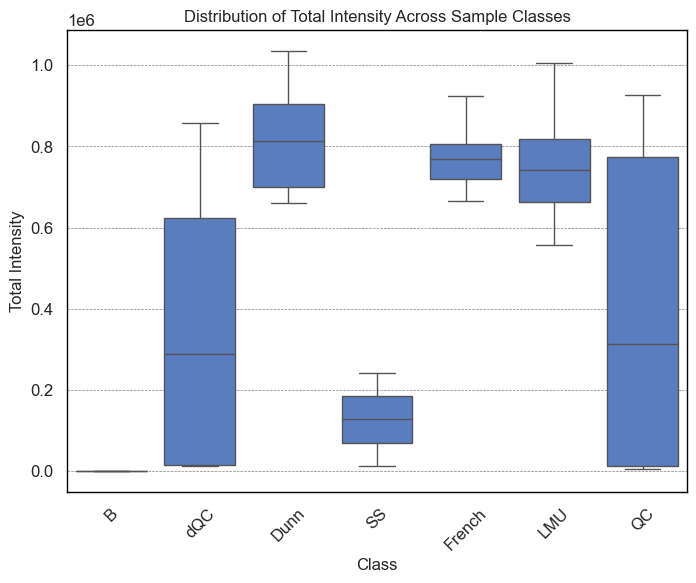

In [49]:
plt.figure()
sns.boxplot(data=intensity_metadata, x='class', y='total_intensity')
plt.title('Distribution of Total Intensity Across Sample Classes')
plt.xlabel('Class')
plt.ylabel('Total Intensity')
plt.xticks(rotation=45)
plt.savefig(f"{config['paths']['figures_dir']}/intensity_by_class.png")
plt.show()

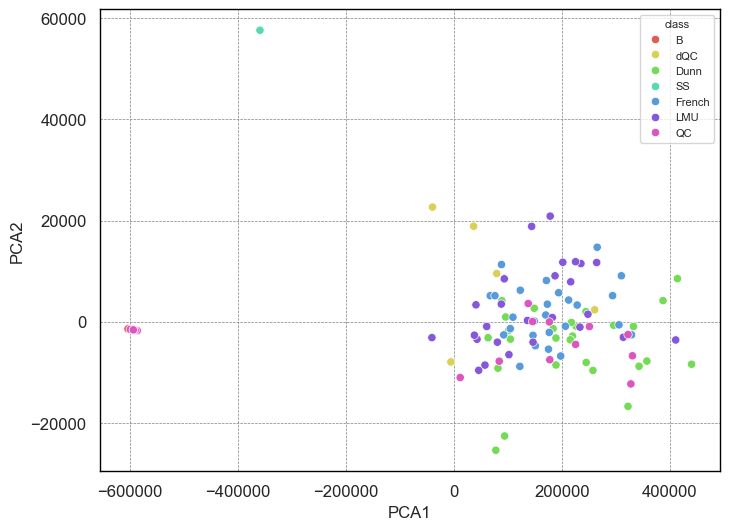

In [72]:
plt.figure()
sns.scatterplot(data=sample_meta, x='PCA1', y='PCA2', hue='class', palette='hls') # PCA colored by class
plt.savefig(f"{config['paths']['figures_dir']}/pca_by_class.png")
plt.show()


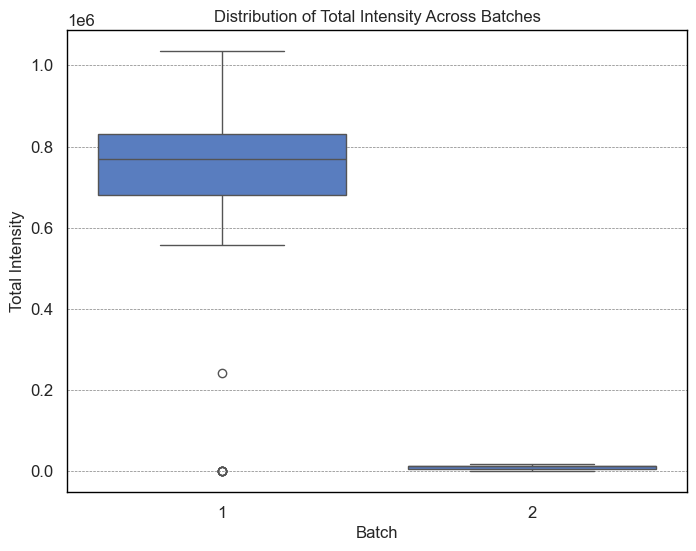

In [51]:
plt.figure()
sns.boxplot(data=intensity_metadata, x='batch', y='total_intensity')
plt.title('Distribution of Total Intensity Across Batches')
plt.xlabel('Batch')
plt.ylabel('Total Intensity')
plt.savefig(f"{config['paths']['figures_dir']}/intensity_by_batch.png")
plt.show()

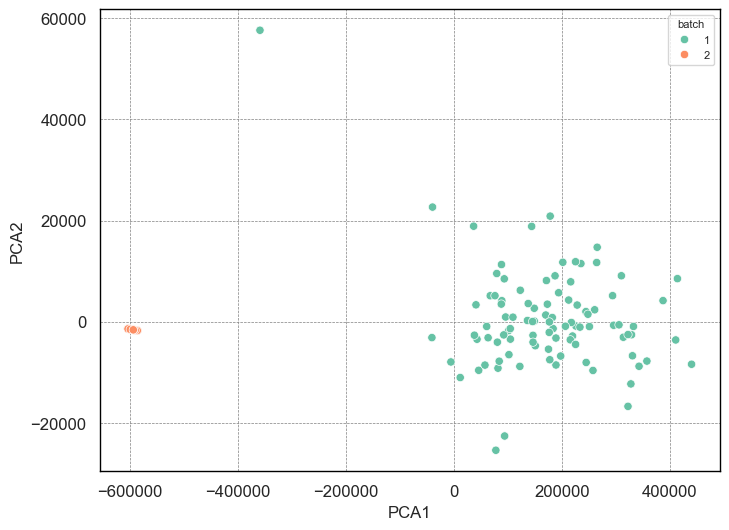

In [73]:

plt.figure()
sns.scatterplot(data=sample_meta, x='PCA1', y='PCA2', hue='batch', palette='Set2') # PCA colored by batch
plt.savefig(f"{config['paths']['figures_dir']}/pca_by_batch.png")
plt.show()

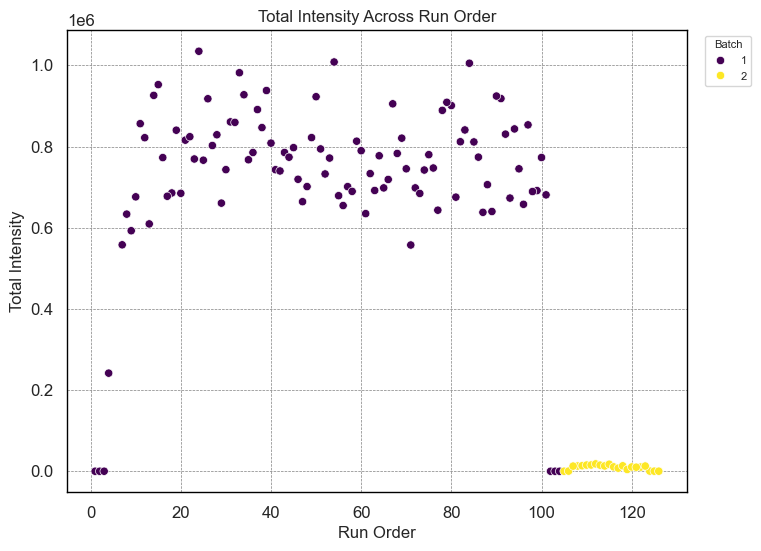

In [54]:
plt.figure()
sns.scatterplot(data=intensity_metadata, x='order', y='total_intensity', hue='batch', palette='viridis')
plt.title('Total Intensity Across Run Order')
plt.xlabel('Run Order')
plt.ylabel('Total Intensity')
plt.legend(title='Batch', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.savefig(f"{config['paths']['figures_dir']}/intensity_by_order.png")
plt.show()

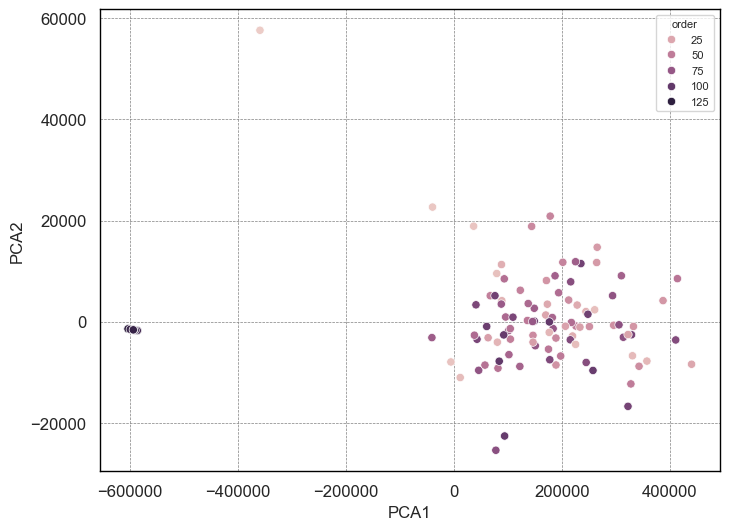

In [75]:

plt.figure()
sns.scatterplot(data=sample_meta, x='PCA1', y='PCA2', hue='order') # PCA colored by order
plt.savefig(f"{config['paths']['figures_dir']}/pca_by_order.png")
plt.show()

### 5. What differences are there between sample classes and/or QCs? Is it consistent across batches?

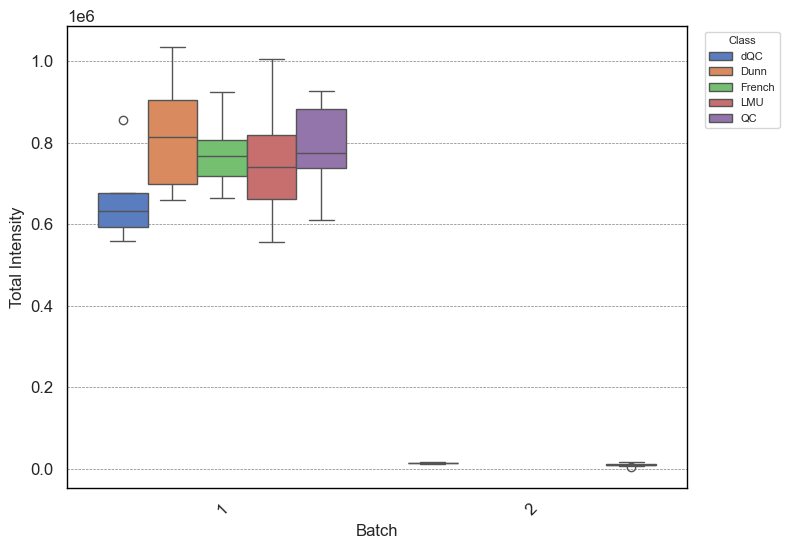

In [84]:
# Plot Intensity Distribution Across Classes Within Each Batch
plt.figure()
sns.boxplot(data=intensity_metadata[~intensity_metadata['class'].isin(['B', 'SS'])], x='batch', y='total_intensity', hue='class')
plt.xlabel('Batch')
plt.ylabel('Total Intensity')
plt.legend(title='Class', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=45)
plt.savefig(f"{config['paths']['figures_dir']}/sample_vs_qc_intensities_by_batch.png")
plt.show()
